<a href="https://colab.research.google.com/github/asegura4488/MetodosComputacionalesI/blob/main/ProeyectoML/EvolutivoAnimGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy

In [128]:
# Configuracion de red neural
sigm = lambda x: 1/(1+np.exp(-x))
class Layer:


    def __init__(self,NC,NN,ActFun,rate=0.2):

        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate

        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )

    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]

    def Mutate(self):

        self.W += np.random.normal( loc=0., scale=self.rate, size=(self.NC,self.NN))
        self.b += np.random.normal( loc=0., scale=self.rate, size=(1,self.NN))

        #self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        #self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))

In [129]:
def GetBrain():
    l0 = Layer(2,5,sigm)
    l1 = Layer(5,1,sigm)
    #l2 = Layer(2,1,sigm)
    Brain = [l0,l1]
    return Brain

In [130]:
Brain = GetBrain()

In [131]:
Brain[1].W

array([[ 8.84838932],
       [-9.21116674],
       [ 8.69722091],
       [-7.64580461],
       [-6.472113  ]])

In [154]:
class Robot:

    def __init__(self,dt,Brain,Id=0):

        self.Id = Id
        self.dt = dt
        self.Fitness = 10.

        # Kinematics
        self.r = np.array([0.,0.])

        theta = np.random.uniform(0.,2*np.pi)
        #theta = 0. # Solo horizontal
        velo = np.random.uniform(0.4,0.6)
        self.v = np.array([velo*np.cos(theta),velo*np.sin(theta)])

        self.Steps = 0.

        # Brain
        self.Brain = Brain
        self.Activation = 0.

    def GetR(self):
        return self.r

    def SetFitness(self):
        self.Fitness = np.linalg.norm(self.v)

    def GetFitness(self):
        return self.Fitness

    def Evolution(self):
        self.r += self.v*self.dt

    def Reset(self):
        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = 10.

    # Brain stuff
    def BrainActivation(self,threshold=0.7):

      for i in range(len(self.Brain)):
        if i == 0:
          output = self.Brain[i].Activation(self.r)
        else:
          output = self.Brain[i].Activation(output)

      self.Activation = np.round(output[0],4)
      return self.Activation

      # Qué hacer si se activa la red

    # Mutamos la configuracion de parametros en cada capa
    def Mutate(self):
      for i in range(len(self.Brain)):
        self.Brain[i].Mutate()

    def GetBrain(self):
      return self.Brain

In [155]:
def GetRobots(N):

    Robots = []

    for i in range(N):
        # Creamos un red para cada bot
        Brain = GetBrain()
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)

    return Robots

In [156]:
dt = 0.05
t = np.arange(0.,1.0,dt)
Robots = GetRobots(10)

In [157]:
def GetPlot():

    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)

    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)

    return ax,ax1

In [158]:
def TimeEvolution(Robots,Plot=True):

    # Aca miramos las activaciones de cada robot
    Activation = np.zeros(len(Robots))

    for it in range(t.shape[0]):

        if Plot:
          clear_output(wait=True)
          ax,ax1 = GetPlot()
          ax.set_title('t = {:.3f}'.format(t[it]))

        for i,p in enumerate(Robots):
            # Aca movemos el robot por el plano
            p.Evolution()

            # Aqui va la activacion cerebral
            # La red debe interactuar con la posición del robot en el plano
            Activation[i] = p.BrainActivation()

            if Plot:
              ax.scatter(p.r[0],p.r[1],label='Id: {}'.format(p.Id))
              ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])

        if Plot:
          ax1.plot(np.arange(0,len(Robots),1),Activation,ls='--',marker='o',color='k')
          ax.legend(loc=0)
          plt.show()
          time.sleep(0.001)

        #print(Activation)

In [159]:
TimeEvolution(Robots,False)

In [162]:
def Genetic(Robots, epochs=50, Plot=True):

    N = int(0.7*len(Robots))

    Fitness = np.array([])

    for e in range(epochs):

        # Reiniciamos y mutamos pesos
        for p in Robots:
          p.Reset()
          p.Mutate()

        # Evolucionamos (episodios en aprendizaje por refuerzo)
        TimeEvolution(Robots,False)

        # Actualizamos fitness
        for p in Robots:
          p.SetFitness()


        # Elegimos los N más aptos
        scores = [(p.Fitness,p) for p in Robots]
        scores.sort(key = lambda x: x[0], reverse = False) # De menos a mayor


        Temp = [ r[1] for i,r in enumerate(scores) if i < N ]

        for i,r in enumerate(Robots):
            j = i%N
            Robots[i] = copy.deepcopy(Temp[j])

        # Miramos fitness de cada robot
        Fitness_ = [ r.GetFitness() for i,r in enumerate(Robots) ]

        # Guardamos la aptitud promedio
        Fitness = np.append(Fitness, np.mean(Fitness_))
        #print(Fitness)

        if e % 2 == 0:

          clear_output(wait=True)

          ax,ax1 = GetPlot()
          ax1.plot(Fitness,color='k',label='Fitness: {:.2f}'.format(Fitness[-1]))
          ax1.legend(loc=0)

          plt.tight_layout()
          plt.show()
          time.sleep(0.001)

    return Robots

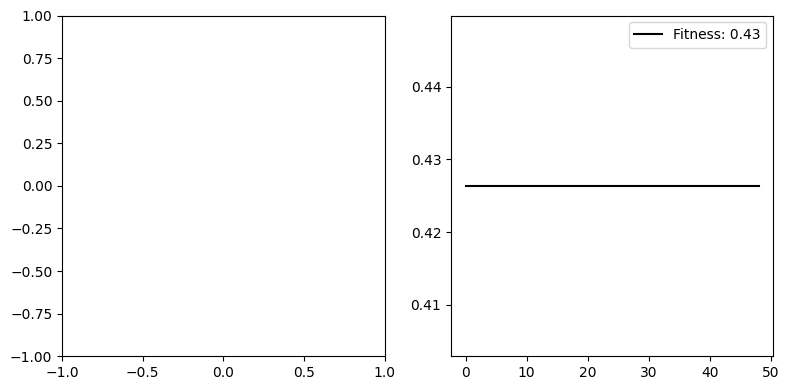

In [164]:
RobotsLuegodeClase = Genetic(Robots)

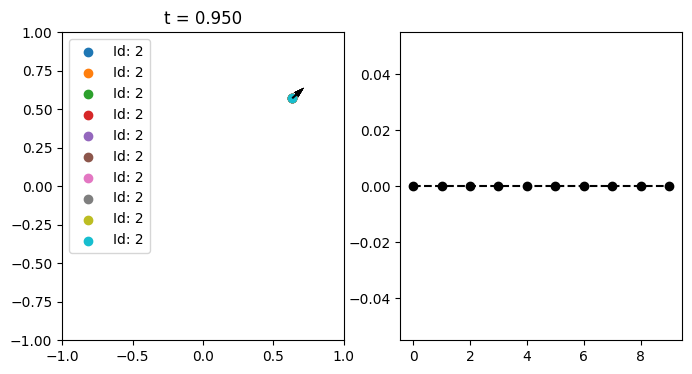

In [166]:
TimeEvolution(RobotsLuegodeClase,True)